In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from lazypredict.Supervised import LazyRegressor
import warnings

In [150]:
warnings.filterwarnings('ignore')
df =pd.read_csv("2-CarPrice_Assignment.csv")

In [151]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [153]:
df.isnull().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [154]:
df.drop("car_ID",axis =1,inplace=True)

In [155]:
df.select_dtypes(include="object").columns

Index(['CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber',
       'fuelsystem'],
      dtype='object')

In [156]:
df["fueltype"].unique()

array(['gas', 'diesel'], dtype=object)

In [157]:
# One-Hot Encoding

df_encoded=df.copy()
categorical_cols = ["fueltype",'aspiration', 'drivewheel', 'fuelsystem']
for col in categorical_cols:
    df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=True)
  
    one_hot_cols = [col for col in df_encoded.columns if df_encoded[col].dtype == 'bool']
    for c in one_hot_cols:
        df_encoded[c] = df_encoded[c].astype(int)

df_encoded['doornumber'] = df_encoded['doornumber'].map({'two': 2, 'four': 4})
df_encoded['enginelocation'] = df_encoded['enginelocation'].map({'front':0, 'rear':1})
df_encoded['cylindernumber'] = df_encoded['cylindernumber'].map({'four':4, 'six':6, 'five':5, 'three':3, 'twelve':12, 'two':2, 'eight':8})


In [158]:
# K-Fold target encoding
kf = KFold(n_splits=5, shuffle=True,random_state=42)
df_encoded['enginetype_encoded'] = np.nan


for train_index, val_index in kf.split(df):
    X_train, X_val = df_encoded.iloc[train_index], df_encoded.iloc[val_index]
    
    # train fold üzerinde enginetype ortalama price
    target_mean = X_train.groupby('enginetype')['price'].mean()
    
    # validation fold’u encode et
    df_encoded.loc[val_index, 'enginetype_encoded'] = X_val['enginetype'].map(target_mean)

median_encoded = df_encoded['enginetype_encoded'].median()
df_encoded['enginetype_encoded']=df_encoded['enginetype_encoded'].fillna(median_encoded)    

In [159]:
df_encoded["enginetype_encoded"].head()

0    18536.545455
1    16707.375000
2    25814.916667
3    11622.540233
4    11487.450568
Name: enginetype_encoded, dtype: float64

In [160]:
df_encoded.drop('enginetype', axis=1, inplace=True)

In [161]:
df_encoded.shape

(205, 32)

In [162]:
df_encoded.select_dtypes(include="object").columns

Index(['CarName', 'carbody'], dtype='object')

In [163]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   symboling           205 non-null    int64  
 1   CarName             205 non-null    object 
 2   doornumber          205 non-null    int64  
 3   carbody             205 non-null    object 
 4   enginelocation      205 non-null    int64  
 5   wheelbase           205 non-null    float64
 6   carlength           205 non-null    float64
 7   carwidth            205 non-null    float64
 8   carheight           205 non-null    float64
 9   curbweight          205 non-null    int64  
 10  cylindernumber      205 non-null    int64  
 11  enginesize          205 non-null    int64  
 12  boreratio           205 non-null    float64
 13  stroke              205 non-null    float64
 14  compressionratio    205 non-null    float64
 15  horsepower          205 non-null    int64  
 16  peakrpm 

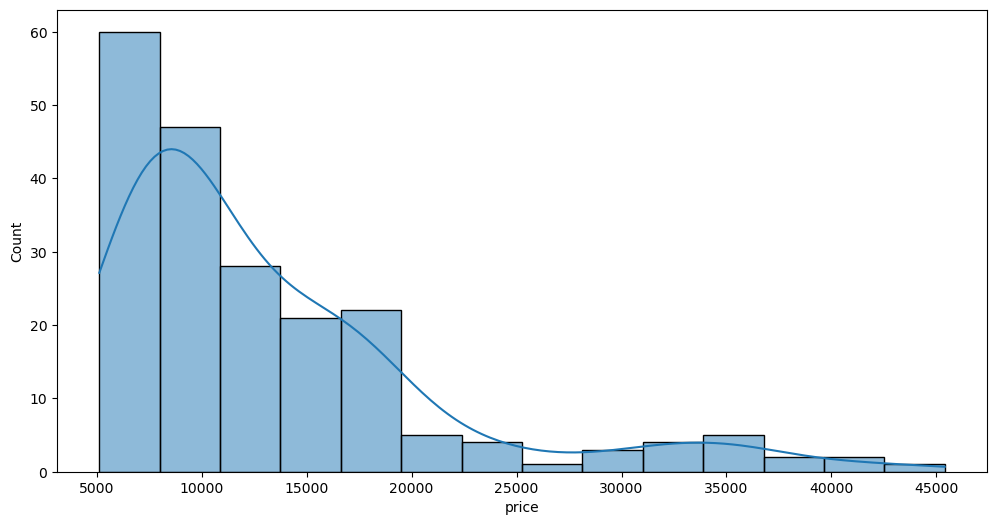

In [164]:
numeric_df = df_encoded.select_dtypes(include='number')
plt.figure(figsize= (12,6))
sns.histplot(df['price'], kde=True)
plt.show()

In [165]:
corr = numeric_df.corr()
corr['price'].sort_values(ascending=False)

price                 1.000000
enginesize            0.874145
curbweight            0.835305
horsepower            0.808139
carwidth              0.759325
cylindernumber        0.718305
carlength             0.682920
drivewheel_rwd        0.638957
wheelbase             0.577816
boreratio             0.553173
fuelsystem_mpfi       0.517075
enginetype_encoded    0.399032
enginelocation        0.324973
aspiration_turbo      0.177926
carheight             0.119336
fuelsystem_idi        0.105679
stroke                0.079443
compressionratio      0.067984
doornumber            0.031835
fuelsystem_mfi       -0.002747
fuelsystem_4bbl      -0.017306
fuelsystem_spfi      -0.019580
fuelsystem_spdi      -0.061475
symboling            -0.079978
peakrpm              -0.085267
fueltype_gas         -0.105679
fuelsystem_2bbl      -0.501374
drivewheel_fwd       -0.601950
citympg              -0.685751
highwaympg           -0.697599
Name: price, dtype: float64

In [166]:
scaler =StandardScaler()
df_scaled =scaler.fit_transform(numeric_df)

In [204]:
# Feature Selection K-Best
X = numeric_df.drop('price',axis=1)
y = numeric_df['price']

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=42)

select = SelectKBest(score_func=f_regression, k=12)
X_train_new = select.fit_transform(X_train, y_train)
X_test_new = select.transform(X_test) 

selected_features = X.columns[select.get_support()]
print("Seçilen En İyi Özellikler:")
print(selected_features)


Seçilen En İyi Özellikler:
Index(['carlength', 'carwidth', 'curbweight', 'cylindernumber', 'enginesize',
       'boreratio', 'horsepower', 'citympg', 'highwaympg', 'drivewheel_fwd',
       'drivewheel_rwd', 'fuelsystem_mpfi'],
      dtype='object')


In [206]:
models ={
    'linear':LinearRegression(),
    'ridge':Ridge(alpha=0.8),
    'lasso':Lasso(alpha=0.01),
}

for name, models in models.items():
    models.fit(X_train,y_train)
    y_pred = models.predict(X_test)

    mae=mean_absolute_error(y_test,y_pred)
    mse=mean_squared_error(y_test,y_pred)
    r2=r2_score(y_test,y_pred)
    print(f"🔹 {name} Models Results:")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}")
    print("-"*40)

🔹 linear Models Results:
MAE: 2042.83, MSE: 9765551.57, R2: 0.88
----------------------------------------
🔹 ridge Models Results:
MAE: 2094.59, MSE: 10415634.40, R2: 0.87
----------------------------------------
🔹 lasso Models Results:
MAE: 2042.80, MSE: 9765039.06, R2: 0.88
----------------------------------------


In [207]:
# Best alpha
alphas = [0.001, 0.01, 0.1, 0.7, 0.8, 1, 1.2, 1.3, 1.4, 1.5 ]
ridge = Ridge()
grid = GridSearchCV(ridge, {'alpha': alphas}, cv=9)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'alpha': 0.8}


In [205]:
#Lazy predict
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train_new, X_test_new, y_train, y_test)

print(models)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 164, number of used features: 12
[LightGBM] [Info] Start training from score 13223.414634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [216]:
new_car_values = np.array([
    172.0,  # carlength
    65.0,   # carwidth
    2800,   # curbweight
    4,      # cylindernumber
    130,    # enginesize
    3.1,    # boreratio
    110,    # horsepower
    24,     # citympg
    30,     # highwaympg
    1,      # drivewheel_fwd
    0,      # drivewheel_rwd
    1       # fuelsystem_mpfi
]).reshape(1, -1)

# Listeyi modelin predict fonksiyonuna ver
predicted_price = final_model.predict(np.array(new_car_values).reshape(1, -1))

print(f" Tahmini Fiyat: {predicted_price[0]:.2f}")

 Tahmini Fiyat: 12527.40
